In [471]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import pandas as pd

## Import data

In [518]:
# load data

x = rasterio.open('../Gao_code/raster/dTRI.tif')
xMatrix = x.read(1)
xMatrix = xMatrix.T
y = rasterio.open('../Gao_code/raster/Cu.tif')
yMatrix = y.read(1)
yMatrix = yMatrix.T

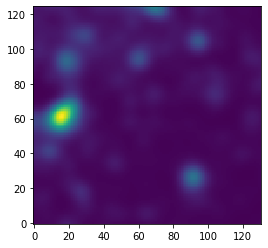

In [19]:
plt.imshow(xMatrix, origin='lower', interpolation='none')

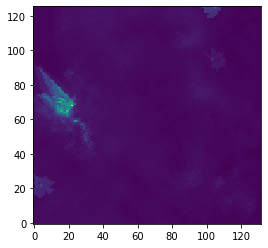

In [20]:
plt.imshow(yMatrix, origin='lower', interpolation='none')

In [26]:
#set parameters

# library sizes
#lib_sizes = np.arange(10,120,20)
lib_sizes = np.arange(10,120,50)

# the dimensions of the embedding   
E<-3                           

array([ 10,  60, 110])

In [519]:
xMatrix.shape

(125, 131)

In [520]:
yMatrix.shape

(126, 132)

## Embedding

In [238]:
from numpy.lib.stride_tricks import sliding_window_view

def expand_matrix(dataMatrix, lagNum):
    # Pad matrix with NA values (numpy.nan)
    return np.pad(dataMatrix, pad_width=lagNum, mode='constant', constant_values=np.nan)

def get_lag_indices(window_dim):
    # used to assign indices to variables of each lag order
    if window_dim % 2 == 0:
        raise ValueError("window_dim must be odd")

    # Create a coordinate grid
    center = window_dim // 2
    y, x = np.ogrid[:window_dim, :window_dim]

    # Calculate the Manhattan distance from the center
    dist = np.maximum(np.abs(y - center), np.abs(x - center))

    return dist.flatten()

def get_lagged_variables(dataMatrix, E):
    # sliding window to get lagged variables for each focal unit
    totalRow, totalCol = xMatrix.shape

    # extracting window of size maxlag around focul unit
    window_dim = E*2 + 1 # window dimension around focal unit
    window = (window_dim,window_dim) # window around focal unit
    
    # pad matrix with nans
    dataMatrix = expand_matrix(dataMatrix, E) 

    # arrays of neighbors for each unit
    laggedVar = sliding_window_view(dataMatrix, window) # gets window around each unit
    laggedVar = laggedVar.reshape(totalRow*totalCol,window_dim*window_dim) # reshape to flatten array

    # layered window indicating position of lag orders (0 focal unit,1, 2,...)
    lag_indices = get_lag_indices(window_dim)
    return laggedVar, lag_indices

def embedding(dataMatrix, E):
    # get neighbors of each unit and position indices of lag orders
    laggedVar, lag_indices = get_lagged_variables(dataMatrix, E) 
    
    # add focal units s
    embedding = [dataMatrix.T] 

    # s(1), s(2), ..., s(E)
    for i in range(1, E + 1):
        lag = laggedVar[:,np.where(lag_indices==i)] # extract neighbors of different order
        embedding.append(lag.squeeze())
        # [0] col x row focal
        # [1] col*row x 8 1st order
        # [2] col*row x 16 2nd order, ...
    return embedding

In [219]:
lag2 = get_lag_indices(5).flatten()
lag2

array([2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 0, 1, 2, 2, 1, 1, 1, 2, 2, 2,
       2, 2, 2])

In [220]:
np.where(lag2==1)

(array([ 6,  7,  8, 11, 13, 16, 17, 18]),)

In [239]:
xEmbedings = embedding(xMatrix, 3)
print(len(xEmbedings))
xEmbedings[3].shape

4


(16375, 24)

In [448]:
def indices_array(m,n):
    r0 = np.arange(m) # Or r0,r1 = np.ogrid[:m,:n], out[:,:,0] = r0
    r1 = np.arange(n)
    out = np.empty((m,n,2),dtype=int)
    out[:,:,0] = r0[:,None]
    out[:,:,1] = r1
    return out

## Prediction 1

In [449]:
idx = indices_array(10,20)[4::5 , 4::5, ].reshape(-1,2)
idx

array([[ 4,  4],
       [ 4,  9],
       [ 4, 14],
       [ 4, 19],
       [ 9,  4],
       [ 9,  9],
       [ 9, 14],
       [ 9, 19]])

In [266]:
idx[:,0]

array([4, 4, 4, 4, 9, 9, 9, 9])

In [267]:
xMatrix.shape

(125, 131)

In [268]:
xMatrix[idx[:,0],idx[:,1]]

array([0.013, 0.015, 0.015, 0.023, 0.019, 0.014, 0.007, 0.008],
      dtype=float32)

In [434]:
# To save computation time, not every pixel is predicted
totalRow, totalCol = xMatrix.shape

predRows = np.arange(4, totalRow + 1, 5)
predCols = np.arange(4, totalCol + 1, 5)

pred = np.array(np.meshgrid(predCols, predRows)).T.reshape(-1, 2)
#xMatrix[pred[:,1], pred[:,0]]
#xMatrix[predRows[:, None], predCols]
#xMatrix[4::5 , 4::5]

In [443]:
pred.shape[0]

650

In [446]:
np.ravel_multi_index(pred[0], (totalRow,totalCol))

528

In [270]:
indexMatrix.shape

(125, 131, 2)

In [395]:
totalRow, totalCol = xMatrix.shape
E=3
lib_size=10
yPred = yMatrix.T

# GCCMSingle(xEmbedings, yPred, 10, pred, totalRow, totalCol, E + 1)

shape = (lib_size,lib_size) # window around focal unit 
indexMatrix = indices_array(totalRow,totalCol)
lib_window = sliding_window_view(xMatrix, shape) # gets window around each unit
lib_indices = sliding_window_view(indexMatrix, shape, (0,1))
lib_indices = lib_indices.reshape(lib_indices.shape[0]*lib_indices.shape[1],2, 10*10)

#To save the computation time, not every pixel is predict. The results are almost the same due to the spatial autodim(correctional 
#If computation resources are enough, this filter can be ignored 
pred = xMatrix[4::5 , 4::5].reshape(-1,2)
pred_indices = indexMatrix[4::5 , 4::5, ].reshape(-1,2)

# delete prediction if nan in data
nan_yMatrix = np.argwhere(np.isnan(yMatrix))
# Create a boolean array indicating where each row in pred_indices matches any row in nan_yMatrix
matches = np.all(pred_indices[:, None, :] == nan_yMatrix[None, :, :], axis=2)
# Get the indices of matching rows
nan_idx = np.where(matches.any(axis=1))[0]
# delete vlaues and indices from list
pred = np.delete(pred, nan_idx, axis=0)
pred_indices = np.delete(pred_indices, nan_idx, axis=0)

In [466]:
bb = np.ones(2 * 2, dtype=bool)
tt = np.array([[np.nan, 1], [2, np.nan]])
bb

array([ True,  True,  True,  True])

In [468]:
bb[np.isnan(tt).flatten()] = False
bb

array([False,  True,  True, False])

In [418]:
pred_indices.shape

(650, 2)

In [420]:
np.ravel_multi_index((4,4), (totalRow, totalCol))

528

In [328]:
lib_indices[0].shape

(2, 100)

In [329]:
pred_indices.shape

(650, 2)

In [330]:
lib_window.shape

(116, 122, 10, 10)

In [331]:
lib_indices.shape[0]

14152

In [410]:
lib_indices = sliding_window_view(indexMatrix, shape, (0,1))
lib_indices.reshape(lib_indices.shape[0]*lib_indices.shape[1], 2, 10*10)[0].T.shape

(100, 2)

In [400]:
pred_indices.shape

(650, 2)

In [408]:
lib_indices.shape

(14152, 2, 100)

In [401]:
nan_yMatrix.shape

(0, 2)

In [ ]:
# run cross map and store results

In [406]:
#for p in pred_indices:
p =  pred_indices[0]
print(p)
np.all(pred_indices[:, None, :] == nan_yMatrix[None, :, :], axis=2)

# Skips to the next iteration if more than half of the values in the library indices are NA

[4 4]


ValueError: operands could not be broadcast together with shapes (14152,2,100) (2,) 

## Prediction 2

In [535]:
from itertools import product
def projection(embeddings, target, lib_indices, pred_indices, E):
    pred = np.full_like(target, np.nan).flatten()

    for p in np.where(pred_indices)[0]:
        lib_indices_copy = lib_indices.copy()
        lib_indices_copy[p] = False
        print(sum(lib_indices))
    return 0

def projection_(embeddings, target, lib_indices, pred_indices, E):
    pred = np.full_like(target, np.nan).flatten()

    for p in np.where(pred_indices)[0]:
        lib_indices = lib_indices.copy()
        temp_lib = lib_indices[p]
        lib_indices[p] = False

        libs = np.where(lib_indices)[0]

        distances = np.mean([np.abs(embeddings[e][libs] - embeddings[e][p]) for e in range(len(embeddings))], axis=0)

        neighbors = np.argsort(distances)[:E+1]
        min_distance = distances[neighbors[0]]

        if np.isnan(min_distance):
            lib_indices[p] = temp_lib
            continue

        if min_distance == 0:
            weights = np.where(distances[neighbors] == 0, 1, 0.000001)
        else:
            weights = np.exp(-distances[neighbors] / min_distance)
            weights = np.maximum(weights, 0.000001)

        total_weight = np.sum(weights)
        pred[p] = np.dot(weights, target[libs[neighbors]]) / total_weight

        lib_indices[p] = temp_lib

    return {'pred': pred, 'stats': compute_stats(target[pred_indices], pred[pred_indices])}

In [537]:
def GCCMSingle(xEmbedings, yPred, lib_size, pred, totalRow, totalCol, E):
    x_xmap_y = pd.DataFrame(columns=['L', 'rho'])
    pred_flat = [np.ravel_multi_index(pred[i], (totalRow,totalCol)) for i in range(pred.shape[0])]

    # sliding library window
    for r, c in product(range(totalRow - lib_size + 1), range(totalCol - lib_size + 1)):
        # initialize flatten mask arrays
        pred_indices = np.zeros(totalRow * totalCol, dtype=bool)
        lib_indices = np.zeros(totalRow * totalCol, dtype=bool)

        pred_indices[pred_flat] = True # mask which pixels in the total matrix should be predicted
        if np.isnan(yPred).any():
            pred_indices[np.isnan(yPred).flatten()] = False # ensure prediction indices do not correspond to NAN values in yPred

        # mask for pixels in current library
        lib_rows = np.arange(r, r + lib_size)
        lib_cols = np.arange(c, c + lib_size)
        lib_ids = np.array(list(product(lib_rows, lib_cols)))
        lib_ids_flat = [np.ravel_multi_index(lib_ids[i], (totalRow,totalCol)) for i in range(lib_ids.shape[0])]
        lib_indices[lib_ids_flat] = True

        # Skips to the next iteration if more than half of the values in the library indices are NA
        if sum(np.isnan(yPred.flatten()[np.where(lib_indices)])) <= (lib_size * lib_size) / 2:
            results = projection(xEmbedings, yPred, lib_indices, pred_indices, E)
            #x_xmap_y = pd.concat([x_xmap_y, pd.DataFrame([{'L': lib_size, 'rho': results['stats']['rho']}])], ignore_index=True)
        else:
            print('skipped', r, c)

    return x_xmap_y

In [538]:
totalRow, totalCol = xMatrix.shape
E=3
lib_size=10
yPred = yMatrix.T
pred = indices_array(totalRow,totalCol)[4::5 , 4::5, ].reshape(-1,2) # filter every 5th pixel

In [539]:
xEmbedings = embedding(xMatrix, E)

In [540]:
GCCMSingle(xEmbedings, yPred, lib_size, pred, totalRow, totalCol, E)

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


KeyboardInterrupt: 

In [479]:
yPred.shape

(132, 126)

In [428]:
from itertools import product
for r, c in product(range(totalRow - lib_size + 1), range(totalCol - lib_size + 1)):
    print(r,c)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 7

In [ ]:
def GCCM(xMatrix, yMatrix, lib_sizes, pred, E, cores=None):
    totalRow, totalCol = xMatrix.shape
    yPred = yMatrix.T

    # construct embedding
    print('Constructing embedding')
    xEmbedings = embedding(xMatrix, E) 

    # initialize 
    x_xmap_y = pd.DataFrame()

    if cores is None:
        for lib_size in lib_sizes:
            print('libsize ', lib_size)
            x_xmap_y = pd.concat([x_xmap_y, GCCMSingle(xEmbedings, yPred, lib_size, pred, totalRow, totalCol, E + 1)])
    else:
        pass

    return x_xmap_y

In [ ]:
x_xmap_y = GCCM(xMatrix, yMatrix, lib_sizes, lib, pred, E, cores=8) 